In [1]:
import os
import os.path as osp
import pandas as pd
import numpy as np
from collections import defaultdict
from tqdm import tqdm

import wandb

In [221]:
DIRNAME = r"/cluster/home/vjimenez/adv_pa_new/results"

In [2]:
def retrieve_from_history(run, keyname):
    return [row[keyname] for row in run.scan_history(keys=[keyname]) if row[keyname] is not None]

In [48]:
def dg_pa_test(
        project: str,
        group: str,
        experiment_name: str,
        filters: dict,
        dirname: str = "results",
        cache: bool = False,
    ) -> pd.DataFrame:

    api = wandb.Api(timeout=100)
    runs = api.runs(project, filters)

    pathdir = osp.join(dirname, group)
    fname = osp.join(pathdir, f"exp={experiment_name}.pkl")
    os.makedirs(dirname, exist_ok=True)

    if cache and osp.exists(fname):
        return pd.read_pickle(fname)

    data = defaultdict(list)
    for i, run in tqdm(enumerate(runs), total=len(runs)):
        config = run.config

        if experiment_name != "_".join(run.name.split("_")[:-1]):
            continue

        # Only to retrieve test results
        try:
            for metric in ["acc", "logPA", "AFR_pred"]:
                data[f"test_{metric}"].append(max(retrieve_from_history(run, f"test/acc_{metric}_epoch")))
                
            data["env_test"].append(config["data/envs_index_test"][0])

            # Config keys
            data["name"].append(run.name)
            data["seed"].append(config["seed"])
            data["n_classes"].append(config["data/n_classes"])
            data["max_epochs"].append(config["trainer/max_epochs"])
            data["model_name"].append(config["model/_target_"].split(".")[-1])
        except:
            continue
        
        # print(run.name)
        # print(data["exp_name"])
        # for pa_metric in ["ASS", "W", "KL", "CS"]:
        #     data[f"test_{pa_metric}"].append(max(retrieve_from_history(run, f"PA(0,1)/{pa_metric}")))
        
    df = pd.DataFrame(data)
    if not osp.exists(pathdir):
        os.mkdir(pathdir)
    df.to_pickle(fname)
    print(f"dataframe stored in {fname}.")
    return df

In [51]:
import matplotlib.pyplot as plt

def dg_pa_test_plot(
        title: str,
        acc_acc: np.array,
        logPA_acc: np.array,
        afr_acc: np.array,
    ):

    fig, ax = plt.subplots(figsize=(6,4))
    x_axis = np.arange(len(acc_acc))
    ax.plot(x_axis, acc_acc, label="Accuracy")
    ax.plot(x_axis, logPA_acc, label="logPA")
    ax.plot(x_axis, afr_acc, label="AFR pred")
    ax.set_title(title, fontsize=12)
    ax.legend(loc="best")
    fig.show()

In [73]:
entity='malvai'
project='DiagVib-6 OOD Model Selection'
group = 'hue_idval_4'

exp_names = ['erm', 'erm_nn', 'irm', 'irm_nn']

df_list = []
for exp_name in exp_names:
    df = dg_pa_test(
        project = entity + '/' + project,
        group = group,
        experiment_name = exp_name,
        filters= {
                "group": group,
                "$and": [{"tags": group}, {"tags": "adam"}]
            },
        cache = True)
    df["group"] = group
    df["experiment_name"] = exp_name
    df_list.append(df)

    # dg_pa_test_plot(
    #     title = f"[{exp_name}] {group}",
    #     acc_acc = df["test_acc"][::-1],
    #     logPA_acc = df["test_logPA"][::-1],
    #     afr_acc = df["test_AFR_pred"][::-1],
    # )
    
df = pd.concat(df_list, axis=0)

100%|██████████| 24/24 [00:09<00:00,  2.46it/s]


dataframe stored in results/hue_idval_4/exp=erm.pkl.


100%|██████████| 24/24 [00:08<00:00,  2.95it/s]


dataframe stored in results/hue_idval_4/exp=erm_nn.pkl.


100%|██████████| 24/24 [00:10<00:00,  2.29it/s]


dataframe stored in results/hue_idval_4/exp=irm.pkl.


100%|██████████| 24/24 [00:09<00:00,  2.63it/s]

dataframe stored in results/hue_idval_4/exp=irm_nn.pkl.


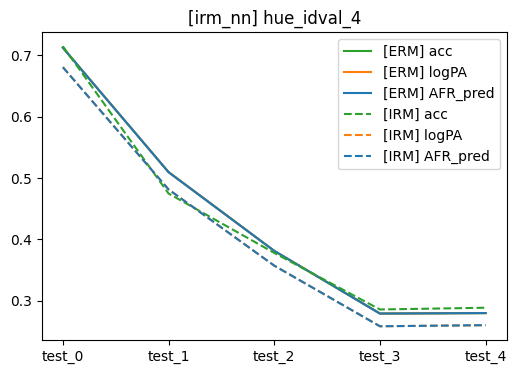

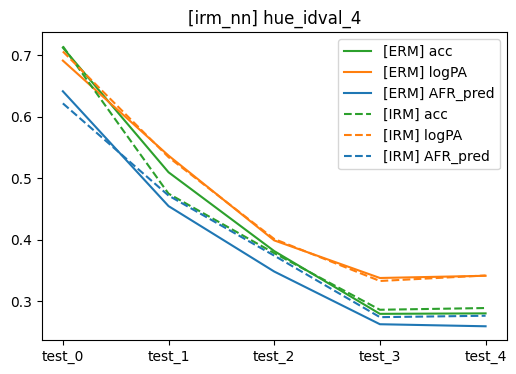

In [74]:
cols = ["tab:green", "tab:orange", "tab:blue"] # for every metric
lins = ["-", "--"] # for every algorithm
for exp in ["", "_nn"]:
    fig, ax = plt.subplots(figsize=(6,4))
    for j, algorithm in enumerate(["erm", "irm"]):
        df_exp = df.loc[df["experiment_name"] == f"{algorithm}{exp}"]
        x_axis = [f"test_{i}" for i in range(len(df_exp["test_acc"]))]
        for i, metric in enumerate(["acc", "logPA", "AFR_pred"]):
            ax.plot(x_axis, df_exp[f"test_{metric}"][::-1], label=f"[{algorithm.upper()}] {metric}", color=cols[i], linestyle=lins[j])

    ax.set_title(f"[{exp_name}] {df_exp['group'][0]}", fontsize=12)
    ax.legend(loc="best")
    fig.show()

In [131]:
def dg_pa_modelselection(
        project: str,
        group: str,
        experiment_name: str,
        filters: dict,
        dirname: str = r"/cluster/home/vjimenez/adv_pa_new/results",
        cache: bool = False,
    ) -> pd.DataFrame:

    api = wandb.Api(timeout=100)
    runs = api.runs(project, filters)

    pathdir = osp.join(dirname, group)
    fname = osp.join(pathdir, f"group={group}_exp={experiment_name}.pkl")
    os.makedirs(dirname, exist_ok=True)

    if cache and osp.exists(fname):
        return pd.read_pickle(fname)

    data = defaultdict(list)
    for i, run in tqdm(enumerate(runs), total=len(runs)):
        config = run.config

        if experiment_name != run.name:
            continue

        # Only to retrieve test results
        try:            
            for epoch in range(5):
                try:
                    data[f"oracle_{epoch}"].append(retrieve_from_history(run, f"oracle/acc_{epoch}_epoch"))
                except:
                    break

            
            data[f"logPA"].append(retrieve_from_history(run, f"PA(0,1)/logPA"))
            data[f"AFR_pred"].append(retrieve_from_history(run, f"PA(0,1)/AFR_pred"))
            data[f"pa_acc"].append(retrieve_from_history(run, f"PA(0,1)/acc_pa"))
            data[f"CS"].append(retrieve_from_history(run, f"PA(0,1)/CS"))
            data[f"val_acc"].append(retrieve_from_history(run, f"val/acc_epoch"))
            
            
            # Config keys
            data["name"].append(run.name)
            data["seed"].append(config["seed"])
            data["n_classes"].append(config["data/n_classes"])
            data["max_epochs"].append(config["trainer/max_epochs"])
            data["model_name"].append(config["model/_target_"].split(".")[-1])
        except:
            continue
        
        # print(run.name)
        # print(data["exp_name"])
        # for pa_metric in ["ASS", "W", "KL", "CS"]:
        #     data[f"test_{pa_metric}"].append(max(retrieve_from_history(run, f"PA(0,1)/{pa_metric}")))
        
    df = pd.DataFrame(data)
    if len(df) == 0:
        return
    
    if not osp.exists(pathdir):
        os.mkdir(pathdir)
    df.to_pickle(fname)
    print(f"dataframe stored in {fname}.")
    return df

In [449]:
entity='malvai'
project='DiagVib-6 OOD Model Selection'
group = 'hue_mixval_4hL'

EXP_NAME = 'erm_f2'

df_list = []
df = dg_pa_modelselection(
    project=entity + '/' + project,
    group=group,
    experiment_name=EXP_NAME,
    filters = {
            "group": group,
            "$and": [{"tags": group}, {"tags": EXP_NAME.split("_")[0]}]
    },
    cache = True,
)

In [450]:
df

,oracle_0,oracle_1,oracle_2,oracle_3,oracle_4,logPA,AFR_pred,pa_acc,CS,val_acc,name,seed,n_classes,max_epochs,model_name
0,"[0.8674395084381104, 0.8729838728904724, 0.855...","[0.6701108813285828, 0.664818525314331, 0.6600...","[0.6313003897666931, 0.6192036271095276, 0.572...","[0.44506049156188965, 0.4614415466785431, 0.41...","[0.45589718222618103, 0.4619455635547638, 0.40...","[-1609.779052734375, -1553.572265625, -1772.57...","[0.974609375, 0.9761618375778198, 0.9730068445...","[0.9868539571762085, 0.9879557490348816, 0.986...","[0.9378462433815002, 0.9379145503044128, 0.940...","[0.9868539571762085, 0.9879557490348816, 0.986...",erm_f2,0,${len:${diagvib_dataset.shape}},100,ERM


In [381]:
def _plot_df(key_y, key_x = None):
    
    y = df[key_y][0]
    if key_x != None:
        x = df[key_x][0]
    else:
        x = [i for i in range(len(y))]
    min_len = min(len(x), len(y))
    return x[:min_len], y[:min_len]

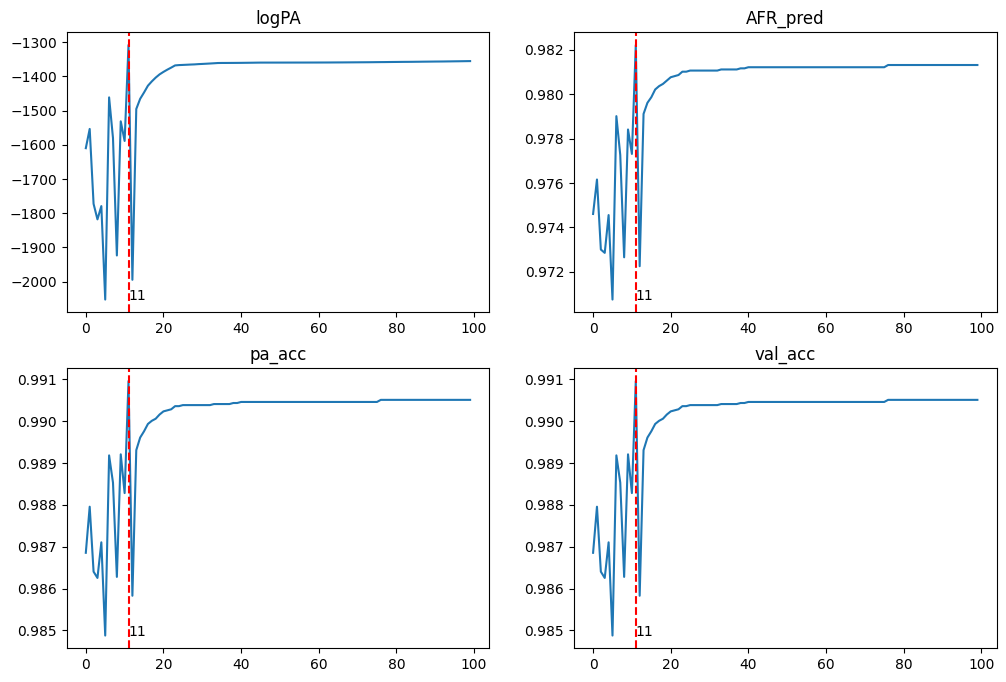

In [453]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(12,8))
for ind_ax, metric in enumerate(["logPA", "AFR_pred", "pa_acc", "val_acc"]):
    ax = axes[ind_ax//2, ind_ax%2]
    x_plot, y_plot = _plot_df(metric)
    ax.plot(x_plot, y_plot)
    x_max = np.argmax(y_plot)
    ax.axvline(x_max, c = 'r', ls="--")
    ax.text(x_max, min(y_plot), s = str(x_max))
    ax.set_title(metric)

# fig.savefig(osp.join(DIRNAME, group, f"{EXP_NAME}_metrics.png"))
fig.show()

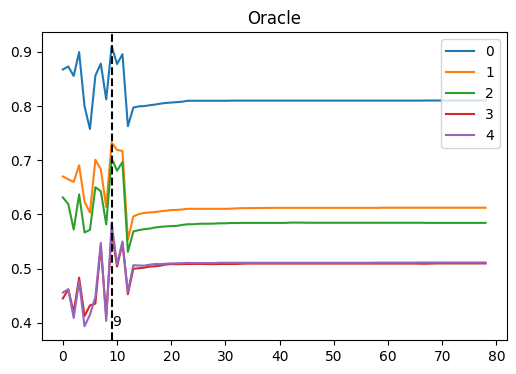

In [383]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(df["oracle_0"][0], label="0")
ax.plot(df["oracle_1"][0], label="1")
ax.plot(df["oracle_2"][0], label="2")
ax.plot(df["oracle_3"][0], label="3")
ax.plot(df["oracle_4"][0], label="4")
x_max = np.argmax(df["oracle_0"][0])
ax.axvline(x_max, ls="--", c='k')
ax.text(x_max, min(df["oracle_4"][0]), s=str(x_max))
ax.set_title("Oracle")
ax.legend(loc='best')
fig.savefig(osp.join(DIRNAME, group, f"{EXP_NAME}_oracle.png"))
fig.show()

In [401]:
def _normalize(x):
    x_max, x_min = max(x), min(x)
    return (np.asarray(x) - x_min)/(x_max - x_min)

0.9653354287147522 0.9378462433815002


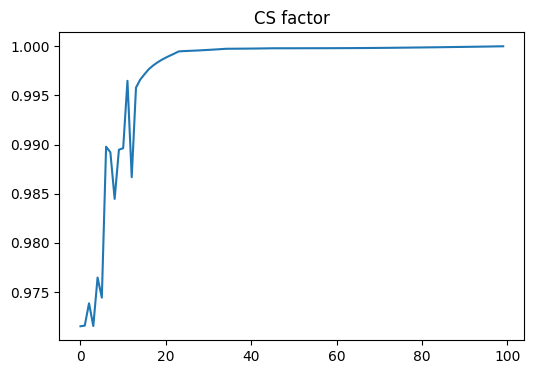

In [459]:
CS = np.array(df["CS"][0])
cs_factor = CS/max(CS)

print(max(CS),min(CS))
# cs_factor = _normalize(CS)

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(cs_factor)
ax.set_title("CS factor")
fig.show()

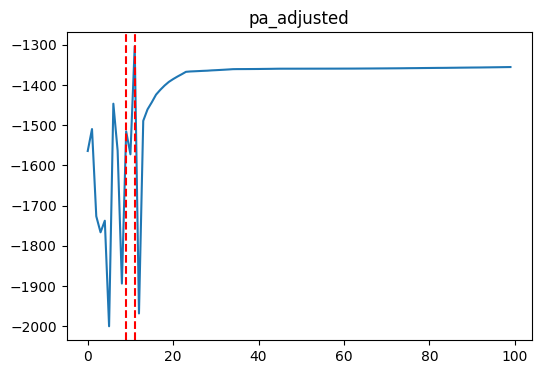

In [460]:
cs_factor = CS/max(CS)

logPA = np.asarray(df["logPA"][0])
pa_adjusted = logPA*cs_factor

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(pa_adjusted)
ax.set_title("pa_adjusted")
ax.axvline(9, c='r', ls="--")
ax.axvline(11, c='r', ls="--")
fig.show()


/tmp/ipykernel_1933/2248424842.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["val_acc"][0] = df["val_acc"][0][:len(df["logPA"][0])]


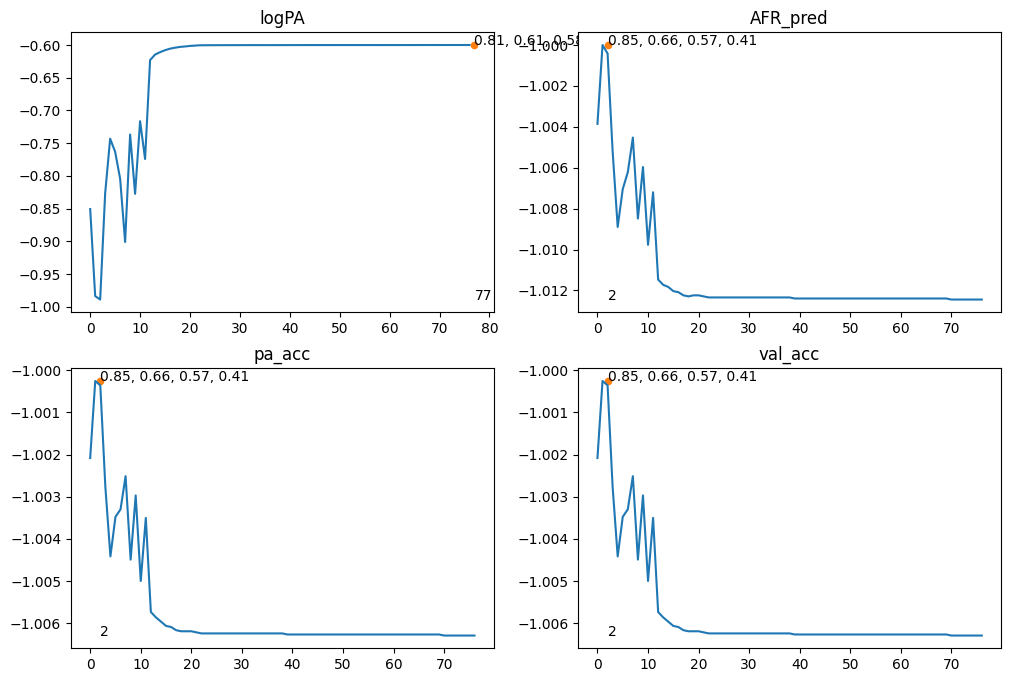

In [386]:
metrics = ["logPA", "AFR_pred", "pa_acc", "val_acc"]
df["val_acc"][0] = df["val_acc"][0][:len(df["logPA"][0])]

weighted_vectors = {
    m: np.zeros(len(df["logPA"][0])-1)
    for m in metrics
}
cs_ratio = np.zeros(len(df["logPA"][0])-1)
# cs_ratio = CS[1:] / CS[:-1]


# max_0 = np.argmax(df["oracle_0"][0])
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8))
for axind, m in enumerate(metrics):
    mval = np.array(df[m][0])
    mval =  - mval / min(mval)
    # for i in range(len(df[m][0])-1):
    #     cs_ratio[i] = CS[i]/CS[i-1]
    #     weighted_vectors[m][i] = (mval[i] - mval[i-1]) * cs_ratio[i]
    #     weighted_vectors[m][i] = mval[i] * cs_ratio[i]
    #     weighted_vectors[m][i] = (mval[i]/mval[i-1]) * cs_ratio[i]

    
    # weighted_vectors[m] = (mval[1:] - mval[:-1]) * cs_ratio

    weighted_vectors[m] = mval[1:]

    # import ipdb; ipdb.set_trace()

    x_max, y_max = np.argmax(weighted_vectors[m]) + 1, max(weighted_vectors[m])
    ax = axes[axind//2, axind%2]
    ax.plot(weighted_vectors[m])
    ax.scatter(x_max, y_max, s = 20, c = "tab:orange")
    ax.text(x_max, y_max,
            s=", ".join([
                str(df[f'oracle_{epoch}'][0][x_max])[:4]
                for epoch in range(4)
            ])
    )
    # ax.axvline(9, ls="--", c="tab:green")
    # ax.axvline(11, ls="--", c="tab:green")

    # ax.text(max_0, min(weighted_vectors[m]), s=str(max_0), c='r')
    ax.text(x_max, min(weighted_vectors[m]), s=str(x_max))
    ax.set_title(m)
# fig.savefig(osp.join(DIRNAME, group, f"{EXP_NAME}_selection.png"))
fig.show()

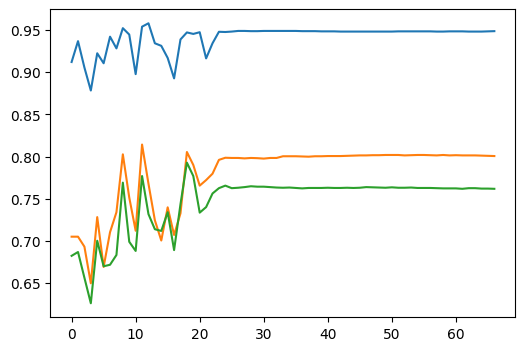

In [297]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(df["oracle_0"][0])
ax.plot(df["oracle_1"][0])
ax.plot(df["oracle_2"][0])
fig.show()

In [298]:
np.argmax(df["oracle_3"][0])

18